In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the data located in /Dataset_creation/df_AD.csv
df_AD = pd.read_pickle('Dataset_creation/df_AD_timestamps.pkl')

# Reset the index
df_AD = df_AD.reset_index(drop=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lbissot (high-contrast-imaging). Use `wandb login --relogin` to force relogin


In [2]:
# features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', \
#     'ESO AOS VISWFS MODE', 'ESO TEL AMBI WINDSP', 'SCFOVROT', 'ESO TEL AMBI RHUM', \
#         'HIERARCH ESO INS4 TEMP422 VAL', 'HIERARCH ESO TEL TH M1 TEMP', 'HIERARCH ESO TEL AMBI TEMP', \
#             'ESO DET NDIT', 'ESO DET SEQ1 DIT', 'SIMBAD_FLUX_G', 'SIMBAD_FLUX_H', 'SEEING_MEDIAN', \
#                 'SEEING_STD', 'COHERENCE_TIME_MEDIAN', 'COHERENCE_TIME_STD', 'SEPARATION', 'NSIGMA_CONTRAST']

features_to_keep = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE', \
    'SEEING_MEDIAN', 'SEPARATION', 'NSIGMA_CONTRAST']

                # 'EFF_NFRA', 'EFF_ETIM', 'SR_AVG' are not included due to the high number of NaN values
                # 'SC MODE' is not included because it is 0 for all the rows

categorical_features = ['ESO INS4 FILT3 NAME', 'ESO INS4 OPTI22 NAME', 'ESO AOS VISWFS MODE']

# The numerical features are the ones that are not categorical
numerical_features = list(set(features_to_keep) - set(categorical_features) - set(['SEPARATION', 'NSIGMA_CONTRAST']))

# Get a dataframe containing only the columns we want to keep
df_AD = df_AD[features_to_keep]

# Convert the strings to numbers in order to transform it into a tensor
df_AD['ESO INS4 FILT3 NAME'] = pd.factorize(df_AD['ESO INS4 FILT3 NAME'])[0]
df_AD['ESO INS4 OPTI22 NAME'] = pd.factorize(df_AD['ESO INS4 OPTI22 NAME'])[0]
df_AD['ESO AOS VISWFS MODE'] = pd.factorize(df_AD['ESO AOS VISWFS MODE'])[0]
# df_AD['SC MODE'] = pd.factorize(df_AD['SC MODE'])[0]

# Convert the columns 'SEPARATION' and 'NSIGMA_CONTRAST' to numpy arrays
separation = np.array(df_AD['SEPARATION'])
nsigma_contrast = np.array(df_AD['NSIGMA_CONTRAST'])

separation_size = len(separation[0])

df_AD.describe()

,ESO INS4 FILT3 NAME,ESO INS4 OPTI22 NAME,ESO AOS VISWFS MODE,SEEING_MEDIAN
count,843.000000,843.000000,843.000000,745.000000
mean,0.820878,0.778173,2.575326,0.988319
std,0.981995,0.719196,1.778055,0.354757
min,0.000000,0.000000,0.000000,0.360000
25%,0.000000,0.000000,1.000000,0.720000
50%,0.000000,1.000000,3.000000,0.945000
75%,2.000000,1.000000,4.000000,1.170000
max,2.000000,3.000000,7.000000,2.875000


As we can see for some features the count value is lower than the number of observations indicating missing values.

In [3]:
import webbrowser

with open('table.html', 'w') as f:
    # f.write(tabulate(test_df, headers='keys', tablefmt='html'))
    f.write(df_AD.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1).to_html())

webbrowser.open('table.html')

True

In [4]:
def reshape_dataframe(df, vec_column_name_list):
    """
    Reshape a dataframe containing vectors in order to have one row per element of the vectors.
    The metadata of the row is repeated for each element of the vectors.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe to reshape
    vec_column_name_list : list
        The list of the columns containing vectors

    Returns
    -------
    df_reshaped : pandas.DataFrame
        The reshaped dataframe
    """

    columns = df.columns
    reshape_dataframe = {}

    # Initialize the dictionary
    for column in columns:
        reshape_dataframe[column] = []

    # Fill the dictionary
    for index, row in df.iterrows():
        # Create a dictionnary with only the metadata of the row, that is without the columns in vec_column_name_list
        meta_dict = row.drop(vec_column_name_list).to_dict()

        # Check whether the dimensions of the vectors are the same
        for column in vec_column_name_list:
            if len(row[column]) != len(row[vec_column_name_list[0]]):
                raise ValueError("The dimensions of the vectors are not the same")

        for i in range(len(row[vec_column_name_list[0]])):
            # Add the metadata to the dictionary
            for key, value in meta_dict.items():
                reshape_dataframe[key].append(value)

            # Add the vector to the dictionary
            for column in vec_column_name_list:
                reshape_dataframe[column].append(row[column][i])

    # Create a dataframe from the dictionary
    df_reshaped = pd.DataFrame(reshape_dataframe)
    return df_reshaped

In [15]:
# Example usage
data = {
    'ID': [1, 2, 3],
    'Name': ['Alice', 'Bob', 'Charlie'],
    'Vector1': [[1, 2], [3, 4, 5], [6, 7]],
    'Vector2': [[0.1, 0.2], [0.3, 0.4, 0.5], [0.6, 0.7]]
}

df = pd.DataFrame(data)
vec_column_name_list = ['Vector1', 'Vector2']
reshaped_df = reshape_dataframe(df, vec_column_name_list)
print(reshaped_df)

   ID     Name  Vector1  Vector2
0   1    Alice        1      0.1
1   1    Alice        2      0.2
2   2      Bob        3      0.3
3   2      Bob        4      0.4
4   2      Bob        5      0.5
5   3  Charlie        6      0.6
6   3  Charlie        7      0.7


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

reshape = True

# Store the number of observations
n_obs = len(df_AD)

# Split the data into train and test sets
train = df_AD.sample(frac=0.8, random_state=0)
test = df_AD.drop(train.index)

# Transform the NaN values into the median of the column of the training set (only for the numerical features)
imp = SimpleImputer(strategy='median')
train[numerical_features] = imp.fit_transform(train[numerical_features])
test[numerical_features] = imp.transform(test[numerical_features])

if reshape:
    # Reshape the dataframes (note that the reshape is done after the train/test split to avoid data leakage)
    train = reshape_dataframe(train, ['SEPARATION', 'NSIGMA_CONTRAST'])
    test = reshape_dataframe(test, ['SEPARATION', 'NSIGMA_CONTRAST'])

    # Split the data into features and labels
    x_train = train.drop(['NSIGMA_CONTRAST'], axis=1)
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['NSIGMA_CONTRAST'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

else:
    # Split the data into features and labels
    x_train = train.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1)
    y_train = train['NSIGMA_CONTRAST']

    x_test = test.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1)
    y_test = test['NSIGMA_CONTRAST']

# Feature names are the columns from train (as a list)
features_names = list(x_train.columns)
n_features = len(features_names)

print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))
print("Learning set size : {}, test set size : {}".format(len(x_train), len(x_test)))

x_train shape : (83576, 5)
y_train shape : (83576,)
Learning set size : 83576, test set size : 20956


In [22]:
x_train.head()

,ESO INS4 FILT3 NAME,ESO INS4 OPTI22 NAME,ESO AOS VISWFS MODE,SEEING_MEDIAN,SEPARATION
0,0,0,4,0.880667,0.030625
1,0,0,4,0.880667,0.038002
2,0,0,4,0.880667,0.045501
3,0,0,4,0.880667,0.053125
4,0,0,4,0.880667,0.060875


In [6]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

x_train[numerical_features].describe()

,SEEING_MEDIAN
count,8.357600e+04
mean,4.897011e-16
std,1.000006e+00
min,-1.855663e+00
25%,-7.053186e-01
50%,-1.226768e-01
75%,4.749045e-01
max,5.658923e+00


In [7]:
# Convert the dataframes to numpy arrays
x_train = x_train.values
y_train = np.array(y_train.tolist())

x_test = x_test.values
y_test = np.array(y_test.tolist())

print("x_train shape : {}".format(x_train.shape))
print("y_train shape : {}".format(y_train.shape))

x_train shape : (83576, 5)
y_train shape : (83576,)


In [8]:
# Log transform of y_train and y_test
y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

In [20]:
def check_array(array):
    for i, row in enumerate(array):
        for j, element in enumerate(row):
            if isinstance(element, (list, tuple, np.ndarray)):
                print(f"Unexpected sequence found at index ({i}, {j}): {element}")
                # Additional actions or error handling can be performed here


In [21]:
check_array(x_train)

# Random Forest Regression

In [8]:
# Define the search grid for hyperparameters
param_grid = {
    'n_estimators': [500], # Number of trees : Always take more trees !
    'max_features': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Define the model
rf_regressor = RandomForestRegressor(random_state=42)

In [10]:
# Perform a grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)
grid_search.fit(x_train, y_train_log)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

In [9]:
best_params = {'max_features': 0.3, 'n_estimators': 500}
# Print the best hyperparameters
print("Best hyperparameters : {}".format(best_params))

Best hyperparameters : {'max_features': 0.3, 'n_estimators': 500}


In [10]:
# Create a new random forest regressor with the best hyperparameters
rf_regressor = RandomForestRegressor(**best_params, random_state=42)

# Fit the model to the training data
rf_regressor.fit(x_train, y_train_log)

RandomForestRegressor(max_features=0.3, n_estimators=500, random_state=42)

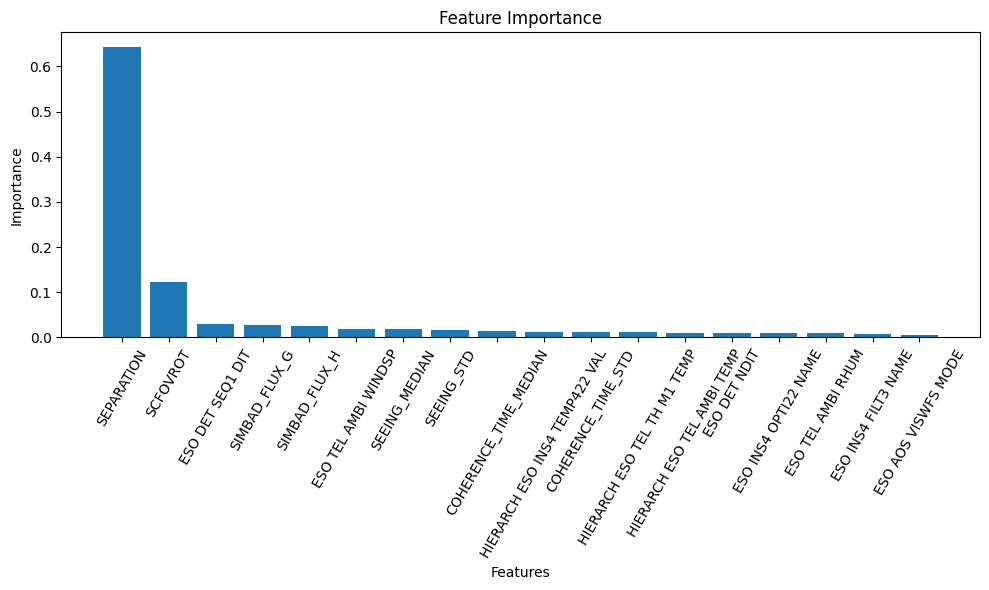

In [11]:
# Get the feature importances
feature_importances = rf_regressor.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(x_train.shape[1]), feature_importances[indices], align="center")
# Probably a good idea to verify that the features are in the same order as the dataframe columns
plt.xticks(range(x_train.shape[1]), [features_to_keep[i] for i in indices], rotation=60)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [12]:
# Use the model to make predictions on the test data
y_pred_log = rf_regressor.predict(x_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test_log, y_pred_log)
r2 = r2_score(y_test_log, y_pred_log)

# Print the results
print("Mean Squared Error: {:.2f}".format(mse))
print("R-squared Score: {:.2f}".format(r2))

Mean Squared Error: 0.21
R-squared Score: 0.89


In [13]:
# Transform the predictions back to the original scale
y_pred = np.power(10, y_pred_log) # 

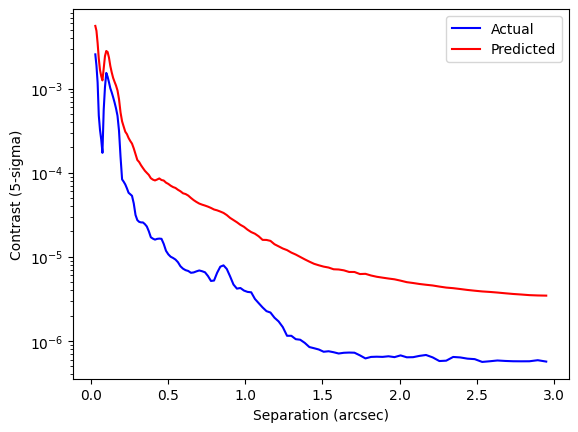

In [14]:
# Plot the predicted values vs the actual ones for one observation
import matplotlib.pyplot as plt

# Choose an observation
idx = 17

x_plot = df_AD['SEPARATION'].iloc[0]

if reshape:
    start = idx * len(x_plot)
    stop = start + len(x_plot)
    y_plot = y_test[start:stop]
    y_pred_plot = y_pred[start:stop]
else:
    y_plot = y_test[idx]
    y_pred_plot = y_pred[idx]

plt.plot(x_plot, y_plot, color='blue', label='Actual')
plt.plot(x_plot, y_pred_plot, color='red', label='Predicted')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.yscale(value='log') # Use only for the results but not for the model evaluation (le delta est plus important sans le log donc c'est mieux pour tune)
plt.legend()
plt.show()

Number of observations in the test set : 169


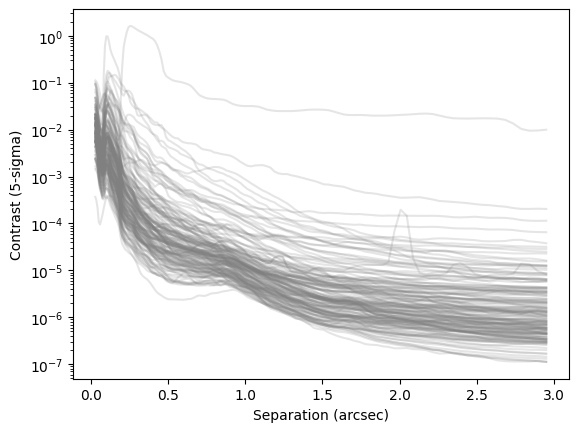

In [15]:
# Check whether the predictions vary or not for different observations
if reshape:
    n_obs_test = int(len(y_pred) / len(x_plot))
else:
    n_obs_test = len(y_pred)
print("Number of observations in the test set : {}".format(n_obs_test))

for idx in range(n_obs_test):
    if reshape:
        start = idx * len(x_plot)
        stop = start + len(x_plot)
        y_plot = y_test[start:stop]
        y_pred_plot = y_pred[start:stop]
    else:
        y_plot = y_test[idx]
        y_pred_plot = y_pred[idx]

    plt.plot(x_plot, y_pred_plot, color='grey', alpha=0.2)

plt.xlabel('Separation (arcsec)')
plt.ylabel('Contrast (5-sigma)')
plt.yscale(value='log')
plt.show()